# Midterm project
# Written by Ben Tankus 2-6-21

## You will have three major tasks, 
### one is to wrangle the data into a format that allows you to do work on it and load it into a database.
   
   #### DONE in group project


 
 
## The next is to answer 3 questions about your data which are moderately complex and provide accompanying visualizations if appropriate (at least 3 total), 
    Questions: 
         1. Is it worth getting more pans dirty? (Is there a positive correlation between spoonscore and equipment count)
            # Viz - Scatter of pan-count to spoon score
         2. What factor contributes the most to spoonscore - Linear Regression - Correlation matrix (check dependent), scatter plot (check assumptions), Bar chart (show relative impact)
         3. Are vegan recipes more expensive? - Scatter
    
    In addition to simply answering the question you should come up with at least 3 visualizations total




## you also need to end up with your data inside an relational database. A local SQLite database would be sufficient.
    #You should load as much of your data as possible into a relational database.



In [622]:
# Initialize stuff
import os, pandas as pd, pprint, numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats



## 1. Is it worth getting more pans dirty? (Is there a positive correlation between spoonscore and equipment count)
            # Viz - Scatter of pan-count to spoon score

In [624]:
# Read File from the same folder
df = pd.read_csv('csvRecipe.csv', index_col = 'id')
df.head()

df.index

Int64Index([247533, 240069, 255341, 277083, 124190,  27162, 252211, 145072,
            225936,  46756,
            ...
            295913, 269445,  68818,   1500, 239487, 254912, 259935, 292297,
              6121, 259751],
           dtype='int64', name='id', length=633)

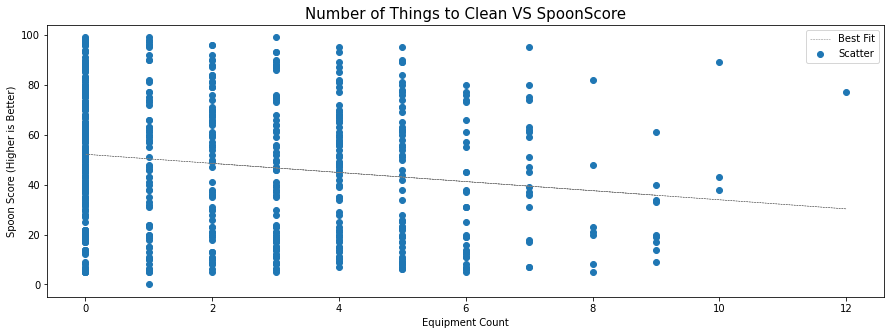

In [660]:
# Initialize
equipmentLen = {}
equipmentLenNoScore = {}

i = 0 # REFORMAT CSV LOOP COUNTER

# REFORMAT EQUIPMENT CSV INTO ROBUST DICTIONARY OF COUNTS
for item in df['equipment']:
    
    #try:  # HANDLE EMPTY EQUIPMENT LISTS
    #print(type(item))
    if type(item) == str:
        item = item.replace("'", "").replace("[", "").replace("]", "")
        itemList = item.split(",") # HANDLES MULTI-WORD TOOLS
        #print('item: ', (itemList), len(list((itemList))))
        equipmentLen[df.index[i]] = (len(itemList), df['spoonScore'].iloc[i])
        equipmentLenNoScore[df.index[i]] = len(itemList)

    else: 
        #print('No Equipment')
        equipmentLen[df.index[i]] = (0, df['spoonScore'].iloc[i])
        equipmentLenNoScore[df.index[i]] = 0


    i += 1

    
# CREATE TUPLES FOR PLOTTING
count, score = [], []
[count.append(x[0]) for x in equipmentLen.values()]
[score.append(x[1]) for x in equipmentLen.values()]

countArray = np.array(count)
scoreArray = np.array(score)
m, b = np.polyfit(countArray, scoreArray, 1)

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)
ax.scatter(count, score, label = 'Scatter')
ax.plot(countArray, m*countArray + b, color = 'grey', linestyle = 'dashed', linewidth = 0.5, label = 'Best Fit')
ax.legend()
ax.set_xlabel('Equipment Count', fontsize=10)
ax.set_ylabel('Spoon Score (Higher is Better)', fontsize=10)
ax.set_title('Number of Things to Clean VS SpoonScore', fontsize=15)

dfLenNoScore = pd.DataFrame(columns = ['id', 'EquipLen']) # CONVERT TO DATAFRAME FOR FUTURE CONCATENATION
dfLenNoScore['id'] = equipmentLenNoScore.keys()
dfLenNoScore['EquipLen'] = equipmentLenNoScore.values()
dfLenNoScore = dfLenNoScore.set_index('id')

Suprisingly, the more equipment you bring out, the worse the spoonscore gets. One would expect improvements in the food quality equivilent to the increase in work / cleanup, but in this case there is roughly a 1.5 point decline in score for each additional equipment item used in the recipe. 

Issues in the analysis:
The equipment list is read in as a string from the CSV when equipment is available, and a float when it's empty. This introduces issues when cleaning the data, as string arguments are not useable in float type data. I handled this with a simple if statement. I also wanted to structure this data for potential future use, so I organized the data in this question into a dictionary with RecipeID key, and a tuple of (EquipmentCount, SpoonScore). This allows for easy understanding of the code at a future date, and easy parsing of the data for future analysis in this project.
The best-fit line was a bit of added complexity. It wasn't required, but I think it adds to the visual. I had to research the basic numpy polynomial fitting procedure, and then add this line to the plot without distracting from the main data. This line shows the reader at a glance if the data is truely negatively or positively correlated.

## 2. What factor contributes the most to spoonscore 
    - Linear Regression - Correlation matrix (check dependent), scatter plot (check assumptions), Bar chart (show relative impact)


In [627]:
# NOT MUCH DETERMINED BY CORR MATRIX, CHECK SCATTER-MATRIX
df.corr()

spoonScore     Vegan  Vegetarian  readyInMinutes  \
spoonScore         1.000000  0.062144   -0.130608        0.012254   
Vegan              0.062144  1.000000    0.487875       -0.030134   
Vegetarian        -0.130608  0.487875    1.000000       -0.059332   
readyInMinutes     0.012254 -0.030134   -0.059332        1.000000   
PricePerServing    0.493565 -0.115034   -0.218434       -0.010088   

                 PricePerServing  
spoonScore              0.493565  
Vegan                  -0.115034  
Vegetarian             -0.218434  
readyInMinutes         -0.010088  
PricePerServing         1.000000

<ipython-input-628-b1c6e6453247>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfQuant['logReadyInMinutes'] = np.log10(dfQuant['readyInMinutes'])
<ipython-input-628-b1c6e6453247>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfQuant['logPricePerServing'] = np.log10(dfQuant['PricePerServing'])


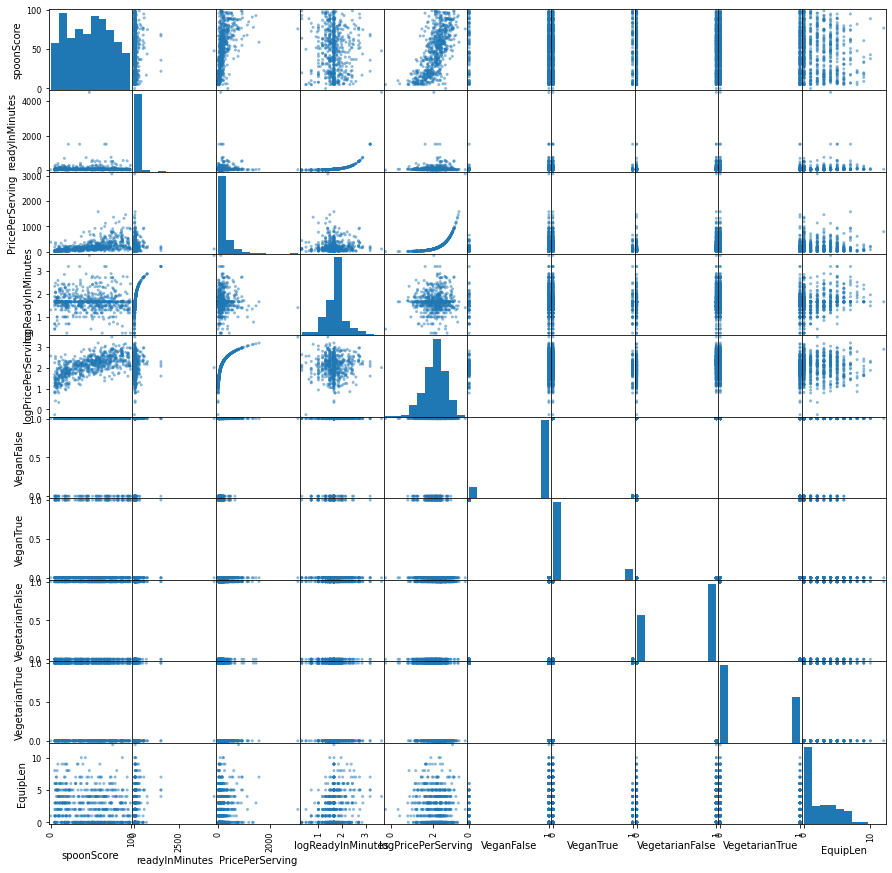

In [628]:
# Scatter matrix
# Factorize vegan and vegetarian variables for use in linear model

dfQuant = df[['spoonScore',  'readyInMinutes', 'PricePerServing']]

dfQuant['logReadyInMinutes'] = np.log10(dfQuant['readyInMinutes'])
dfQuant['logPricePerServing'] = np.log10(dfQuant['PricePerServing'])


dfVegan = pd.get_dummies(df['Vegan'])
dfVeganHalf = dfVegan.rename(columns = {False: 'VeganFalse', True: 'VeganTrue'})

dfVegetarian = pd.get_dummies(df['Vegetarian'])
dfVegetarianHalf = dfVegetarian.rename(columns = {False: 'VegetarianFalse', True: 'VegetarianTrue'})
dfFullModel = pd.concat([dfQuant,dfVeganHalf, dfVegetarianHalf,dfLenNoScore ], axis = 1)

scatterMatrix = pd.plotting.scatter_matrix(dfFullModel, figsize = (15, 15))

Really the only thing that correlates is spoonscore with price per serving and equipment length. The log(pricePerServing) correlates a bit better but not enough to risk the increase of model complexity that the addition of this term would do. I reccomend creating the model with just spoonscore VS pricePerServing. There is strong multicolinearity with log(readyInMinutes) and equipment length which makes sense. As the equipment length increases, it will take more time. I will add an interaction term for this. Using log here is relevant due to the wide variance of the readyinminutes field. Many recipes take 15 minutes, but many also take 60min - 200min.

### Linear Regression model using:
    Spoonscore = Beta0 + Beta1(PricePerServing) + Beta2(EquipmentCount) + Beta3(ReadyInMinutes:EquipmentCount) + Error

LinearRegression()

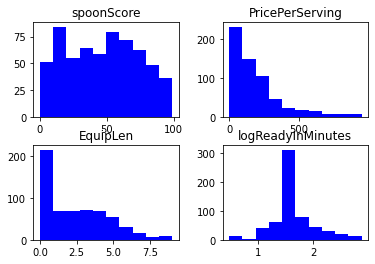

In [640]:

# Create relevant dataframe
dfLR = dfFullModel[['spoonScore', 'PricePerServing', 'EquipLen', 'logReadyInMinutes']]

pd.DataFrame.to_csv(dfLR, 'cleanDF.csv')

# Drop outliers
dfLR = dfLR[(np.abs(stats.zscore(dfLR['PricePerServing'])) < 3)] # Drop rows less than 3 stdev from zscore
dfLR = dfLR[(np.abs(stats.zscore(dfLR['EquipLen'])) < 3)]
dfLR = dfLR[(np.abs(stats.zscore(dfLR['logReadyInMinutes'])) < 3)]

X = dfLR.drop('spoonScore', axis = 1)
Y = list(dfLR['spoonScore'])

# Create train / test params

dfLR.hist(grid = False, color = 'blue')
fitLM = LinearRegression()
fitLM.fit(X, Y)


In [670]:
intercept = fitLM.intercept_
coefficient = fitLM.coef_
print('Intercept', intercept, 'coef', coefficient)

Intercept 35.40521478795492 coef [ 0.08153334 -1.90982944  0.22817907]


### I can't figure out how to fit a linear model with interaction terms in python, so I finished fitting the full model in R. The interaction term had a pvalue of 0.63 meaning it's not valuable, so continue with the three non-interaction terms.
    For reference, pvalues for intercept, priceperserving, equipmentlen, and logreadyinminutes are 1.4e-06, 2.6e-12, 0.03, and 0.04 respectively

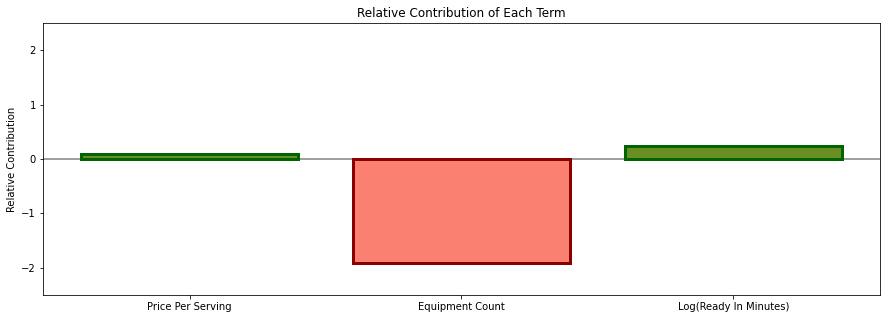

In [669]:
fig = plt.figure( figsize = (15, 5))
ax = fig.add_subplot(111)
ax.set(title = 'Relative Contribution of Each Term', ylabel = 'Relative Contribution')
ax.set_ylim(-2.5,2.5)
vert_bars = ax.bar(['Price Per Serving','Equipment Count','Log(Ready In Minutes)'], coefficient)

for bar, height in zip(vert_bars, coefficient):
    if height < 0:
        bar.set(color='salmon', edgecolor='darkred', linewidth=3)
    else:
        bar.set(color='olivedrab',edgecolor='darkgreen', linewidth=3)

ax.axhline(zorder = -1, color = 'grey')

## 3. Are vegan recipes more expensive? 
    - Scatter plot

In [632]:
dfQ3 = df[['Vegan', 'PricePerServing']]
dfQ3 = dfQ3[(np.abs(stats.zscore(dfQ3['PricePerServing'])) < 3)] # Drop rows less than 3 stdev from zscore

#dfQ3 = pd.concat([pd.get_dummies(dfQ3['Vegan']), dfQ3['PricePerServing']], axis = 1)

[Text(0.5, 0, 'Non - Vegan Histogram')]

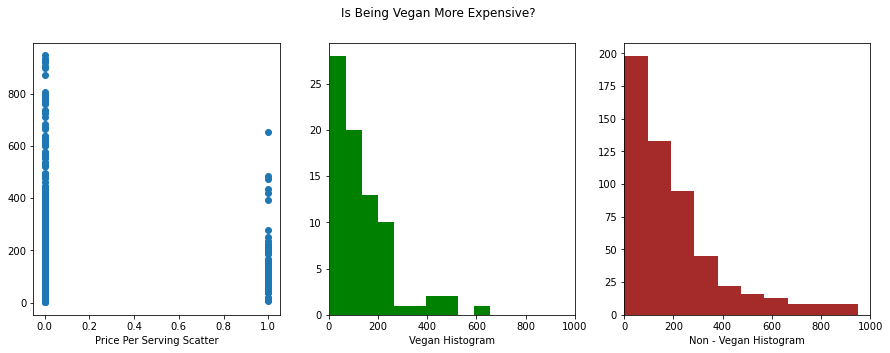

In [657]:
fig = plt.figure(figsize = (15, 5))
ax = fig.subplots(ncols=3)
fig.suptitle('Is Being Vegan More Expensive?')
#fig.size()
ax[0].scatter(dfQ3['Vegan'], dfQ3['PricePerServing'])
ax[0].set(xlabel = 'Price Per Serving Scatter')

veganSeries = dfQ3[dfQ3['Vegan'] == True]['PricePerServing']
ax[1].hist(veganSeries, color = 'green')
ax[1].set_xlim(0, 1000)
ax[1].set(xlabel = 'Vegan Histogram')



nonVeganSeries = dfQ3[dfQ3['Vegan'] != True]['PricePerServing']
ax[2].hist(nonVeganSeries, color = 'brown')
ax[2].set_xlim(0, 1000)
ax[2].set(xlabel = 'Non - Vegan Histogram')




In [634]:
print("Vegan Series")
print(veganSeries.describe())
print('\nNon Vegan Series')
print(nonVeganSeries.describe())

Vegan Series
count     78.000000
mean     134.735513
std      122.415348
min        6.220000
25%       55.190000
50%      102.555000
75%      182.417500
max      654.720000
Name: PricePerServing, dtype: float64

Non Vegan Series
count    546.000000
mean     201.447747
std      192.477608
min        0.560000
25%       62.865000
50%      147.565000
75%      262.110000
max      948.160000
Name: PricePerServing, dtype: float64


From both the tables and the plots it can be seen that the mean price for vegan food is less than non-vegan food. 